# Clustering-based Analysis of Handwritten Digits

This notebook is part of the DHNB 2022 tutorial "Introduction to Text and Image Analysis Using Python" (website: [https://raphaelaheil.github.io/2022-03-15-dhnb/](https://raphaelaheil.github.io/2022-03-15-dhnb/)). 

## Session Objectives

- demonstrate a general image processing pipeline
- provide an example of how clustering can be used to annotate data

## Dataset

This notebook uses the following dataset:
> "DIDA is a new image-based historical handwritten digit dataset and collected from the Swedish historical handwritten document images between the year 1800 and 1940"
>
> from [https://didadataset.github.io/DIDA/](https://didadataset.github.io/DIDA/)

>A Deep Handwritten Digit Detection and Recognition Method Using a New Historical Handwritten Digit Dataset, Huseyin Kusetogullari, Amir Yavariabdi, Johan Hall, Niklas Lavesson,
DIGITNET: 
Big Data Research,
Volume 23,
2021,
100182,
ISSN 2214-5796,
https://doi.org/10.1016/j.bdr.2020.100182.
(https://www.sciencedirect.com/science/article/pii/S2214579620300502)

Original dataset download: [https://didadataset.github.io/DIDA/](https://didadataset.github.io/DIDA/)

Workshop dataset download: [https://github.com/RaphaelaHeil/clustering-dhnb/releases/download/v1.0/digits.zip](https://github.com/RaphaelaHeil/clustering-dhnb/releases/download/v1.0/digits.zip)

_For usability reasons, the original dataset has been restructured and compressed as a *.zip, instead of *.rar for the purpose of the workshop. The images themselves however remain unchanged._

## General Pipeline

1. Load images
2. Preprocess
    1. resize images to fixed dimensions (64x64px)
    2. turn colour (RGB) images into greyscale
    3. turn greyscale images into black and white ("[Otsu's Method](https://en.wikipedia.org/wiki/Otsu%27s_method)")
4. Extract features ("[Histogram of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)")
5. Cluster features ("[k-Means](https://en.wikipedia.org/wiki/K-means_clustering)") 

![Visualisation of intermediate results of the processing pipeline](pipeline.svg)

Clustering-based Analysis of Handwritten Characters--- 

## Required Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import utils

### Brief introduction of the main packages:

**Matplotlib**
> Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
>
> from [https://matplotlib.org/](https://matplotlib.org/)

Documentation: [https://matplotlib.org/stable/api/index](https://matplotlib.org/stable/api/index)

Extensive gallery of examples: [https://matplotlib.org/stable/gallery/index.html](https://matplotlib.org/stable/gallery/index.html)

**Numpy**
> "NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more." 
>
> from [https://numpy.org/](https://numpy.org/)

Documentation: [https://numpy.org/doc/stable/reference/index.html#reference](https://numpy.org/doc/stable/reference/index.html#reference)

**Skimage (scikit-image)**
> "scikit-image is a collection of algorithms for image processing."
>
> from [https://scikit-image.org/](https://scikit-image.org/)

Documentation: [https://scikit-image.org/docs/stable/api/api.html](https://scikit-image.org/docs/stable/api/api.html)

Gallery of examples: [https://scikit-image.org/docs/stable/auto_examples/index.html](https://scikit-image.org/docs/stable/auto_examples/index.html)

**Sklearn (scikit-learn)**
> "Simple and efficient tools for predictive data analysis."
> 
> from [https://scikit-learn.org/](https://scikit-learn.org/)

Documentation: [https://scikit-learn.org/stable/modules/classes.html](https://scikit-learn.org/stable/modules/classes.html)

User guide: [https://scikit-learn.org/stable/user_guide.html](https://scikit-learn.org/stable/user_guide.html)

**utils**

A utility package, made specially for this tutorial. It contains helper methods for loading, processing and visualising the data.

## 1 Loading the data

_You can skip the following cell if you have already downloaded and extracted the data, e.g. if you have run this notebook on this computer before._

In [4]:
utils.retrieve_dhnb_images()

Successfully donwloaded dataset!


Next, we are loading the images into the notebook, using a helper method:

_There are 1000 images per digit in the dataset but processing all of them will take some time, so we will only use 100 images per digit here. Feel free to experiment with other numbers on your own!_

In [6]:
images, labels = utils.read_all_images(images_per_digit=100)

Loaded 1000 images from: dida_single_digit_10k


   

To get an idea of what our dataset contains, we will look at the first 100 images. 

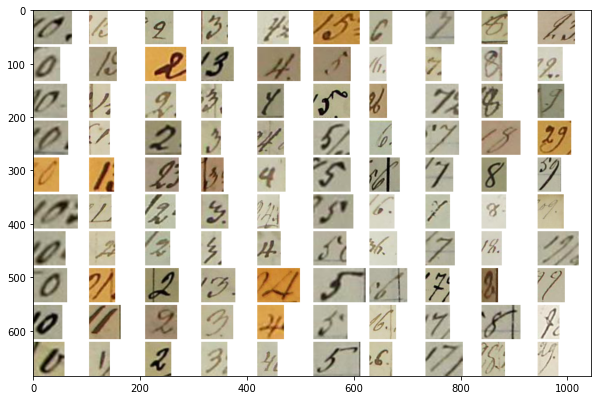

In [7]:
utils.digit_grid(images[:100])

As we can see above, the images are of varying shapes, colours and hues. Varying shapes can be an issue when we are comparing images or intermediate representations, while colour and hue can affect the classification outcome. We might, for example, end up with all images with an orange background in one group, regardless of what digit is shown. Since we want to classify the digit and not the colour, we will remove these "distracting" pieces of information below. This step is referred to as pre-processing.

## 2 Pre-processing

1. resize images to fixed dimensions (64x64px)
2. turn colour (RGB) images into greyscale
3. turn greyscale images into black and white ("[Otsu's Method](https://en.wikipedia.org/wiki/Otsu%27s_method)")

### 2.1 Resize

In [8]:
resized_images = []
for original_image in images:
    fixed_size_image = resize(original_image, (64,64))
    resized_images.append(fixed_size_image)

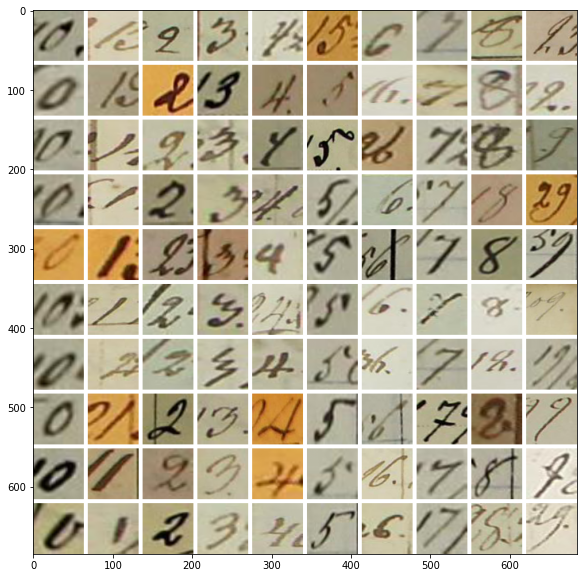

In [9]:
utils.digit_grid(resized_images[:100])

### 2.2 Greyscale Conversion

In [10]:
greyscale_images = []
for colour_image in resized_images:
    grey_image = rgb2gray(colour_image)
    greyscale_images.append(grey_image)

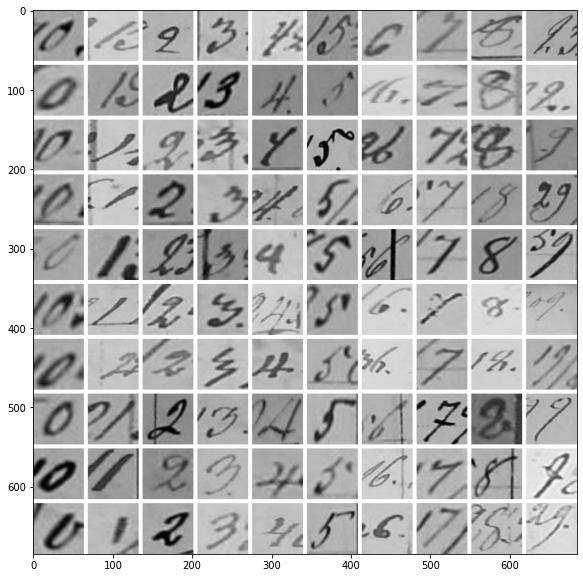

In [11]:
utils.digit_grid(greyscale_images[:100])

### 2.3 Conversion to Black and White

There is still quite a bit of variation in background and ink colour across the images. Since our goal is to identify the digits themselves, we will remove this information, so that the only thing that remains is which pixels are part of an ink-stroke and which are not. 

This is done via a process called "thresholding". Each pixel in the image has a value assigned to it that represents the colour, or in the greyscale case, how light/dark it is. We can define a threshold value to separate between light and dark areas in the image. Everything that is lighter than the threshold becomes white and everything that is darker becomes black. 

Below, we use a method called [Otsu's thresholding](https://en.wikipedia.org/wiki/Otsu%27s_method), to determine which is the best cut-off point for each image. Alternatively we could also define a fixed value for all imges, manually, by replacing line 3:

`threshold = threshold_otsu(grey_image)` 

with 

`threshold = "value of your choice between 0 and 1"`, 

e.g.:

`threshold = 0.5`.

Feel free to try out different manual thresholds (between 0 and 1) and see how they affect the images in the cell below, as well as the rest of the pipeline.

In [12]:
black_and_white_images = []
for grey_image in greyscale_images:
    threshold = threshold_otsu(grey_image)
    bw_image = (grey_image > threshold)*1.0 
    black_and_white_images.append(bw_image)

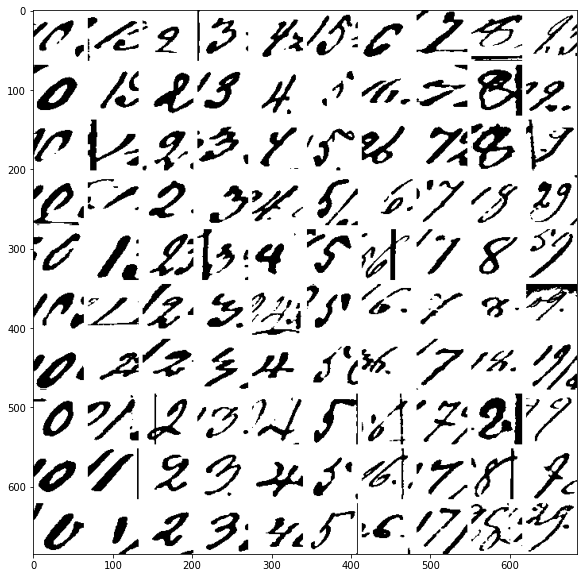

In [13]:
utils.digit_grid(black_and_white_images[:100])

## 3 Feature Extraction: Histogram of Oriented Gradients

As shown in the black and white figure above, we have reduced the digits to a fundamental image representation by removing the colour information. We can reduce this information even further by extracting characteristic *features* that summarise the image content in some form. This step can improve the performance of the "down-stream" task. Since these *feature representations* are generally smaller than the original images, they also speed up the subsequent processing steps. 


There are many different ways to extract *features* and not all methods work well for all tasks. Here, we will use what is called the "[Histogram of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)" (HOG). In short, HOG divides an image into regions and looks at the directions of the edges in each.

![Visualisation of the gradients used in the Histogram of Oriented for the digit "7"](hog.png)

In [14]:
hog_features = []
for bw_image in black_and_white_images:
    histogram_oriented_gradients = hog(bw_image, pixels_per_cell=(16,16))
    hog_features.append(histogram_oriented_gradients)

In [15]:
print("Original image size", 64*64)
print("HOG feature size", len(hog_features[0]))
print("HOG features", hog_features[0])

Original image size 4096
HOG feature size 324
HOG features [0.         0.         0.04098963 0.         0.04347606 0.
 0.         0.         0.         0.         0.         0.
 0.         0.02898404 0.         0.04098963 0.         0.
 0.         0.         0.12296888 0.         0.11593617 0.
 0.         0.         0.         0.05796809 0.         0.32375324
 0.         0.30433245 0.         0.04098963 0.         0.
 0.05796809 0.         0.32375324 0.         0.10144415 0.
 0.         0.         0.         0.17390426 0.         0.32375324
 0.         0.27534841 0.         0.10247407 0.         0.
 0.23187235 0.         0.32375324 0.         0.04347606 0.
 0.         0.         0.         0.17390426 0.         0.32375324
 0.         0.04347606 0.         0.04098963 0.         0.
 0.11593617 0.         0.32375324 0.         0.07246011 0.
 0.02049481 0.         0.         0.         0.         0.
 0.         0.03800743 0.         0.05375062 0.         0.
 0.         0.         0.1612518

## 4 Clustering: k-Means Algorithm

Using the HOG features from above, in the next step, the image will be clustered together into groups. Ideally, these groups are homogeneous, so that we can provide the same annotation for all of them at once, instead of going through each image individually. 

In order to identify these groups, we will use [k-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering). A detailed explanation of this algorithm is beyond the scope of this tutorial. Briefly summarised, it performs the following steps: 

1. pick **N** random initial cluster centres
2. assign each datapoint to its closest centre to form data clusters
3. calculate the means of the data in each cluster; these means become the new cluster centres
4. repeat steps 2 and 3 until the clusters don't change drastically any more 

The number of clusters **N** is user-defined and we will experiment with a couple of manual choices. Detailed tips on how to choose this number are e.g. given by the [Programming Historian](https://programminghistorian.org/en/lessons/clustering-with-scikit-learn-in-python#how-many-clusters-should-i-choose).

In [16]:
number_of_clusters = 10
kmeans = KMeans(n_clusters=number_of_clusters)
cluster_labels = kmeans.fit_predict(hog_features)
print(cluster_labels)

[1 9 2 2 4 1 2 4 2 4 1 4 4 2 4 4 2 9 2 2 1 6 2 2 8 7 0 3 2 6 1 9 2 4 9 8 9
 3 1 8 5 4 4 6 0 7 0 3 7 3 1 9 2 2 9 0 7 7 2 3 1 9 9 2 2 8 7 3 2 1 1 1 6 2
 6 8 0 9 2 3 1 1 9 3 9 8 0 3 7 8 1 4 9 2 9 7 2 3 7 3 2 6 4 2 2 7 2 3 7 7 1
 4 2 1 1 8 5 3 2 2 1 4 6 2 9 0 0 3 2 0 0 6 9 2 2 7 5 4 8 3 1 9 9 2 4 8 0 3
 2 3 1 0 5 2 6 8 0 3 1 3 8 4 9 3 9 7 0 3 2 7 1 6 9 2 8 4 0 3 3 9 1 4 2 2 0
 8 0 3 0 1 2 4 1 6 6 8 5 3 2 3 1 9 2 3 6 8 7 3 2 3 1 0 2 6 9 8 0 3 0 1 1 6
 8 2 0 7 5 3 0 3 1 4 5 6 2 7 8 3 2 6 1 6 2 4 0 7 0 0 5 1 1 1 9 2 2 7 5 7 5
 1 4 8 9 8 9 1 1 5 2 1 1 6 9 9 3 5 5 3 5 6 1 4 6 6 0 8 5 6 2 3 1 4 6 2 0 7
 0 9 5 1 8 4 8 2 1 8 2 3 0 2 0 4 9 1 0 8 2 7 5 1 1 1 9 1 3 8 0 2 5 2 1 1 2
 8 9 8 5 3 2 8 0 0 6 9 0 8 0 9 4 9 1 4 8 3 9 7 5 9 3 1 1 1 9 8 2 7 0 6 2 4
 0 4 9 8 1 8 5 3 1 3 1 6 9 2 0 8 0 3 2 1 1 4 9 8 7 3 0 3 8 1 1 4 9 2 0 7 0
 3 5 2 1 4 9 6 4 7 9 3 2 3 1 4 6 2 8 8 5 3 5 1 1 4 4 8 2 0 5 3 5 3 1 4 9 1
 1 2 0 3 0 6 1 0 6 6 9 7 0 3 2 8 2 0 9 8 4 7 0 3 5 4 1 4 0 1 2 8 0 3 7 1 1
 0 8 2 9 8 0 6 8 3 1 6 2 

Regarding the _cluster_labels_ output above, it has to be pointed out that these numbers have no relation to the actual digits that we have seen in our images. k-Means will create **N** clusters and give each one a number, regardless of what it contains. One could for example also represent these _cluster_labels_ as letters. 

To emphasise this, let's look at what each cluster contains. For each one, we will take all images in that cluster and calculate the mean image. This will give us a kind of heatmap, showing us the image areas in which we have a lot, or very little, ink.

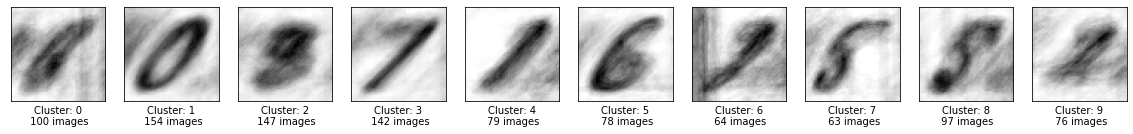

In [17]:
heatmaps = []

fig, ax = plt.subplots(ncols=number_of_clusters, figsize = (20,10))

for cluster_id in range(number_of_clusters):
    selected = np.array(black_and_white_images)[cluster_labels == cluster_id]
    meanImage = np.mean(selected, axis=0)
    heatmaps.append(meanImage)
    ax[cluster_id].imshow(meanImage, cmap="gray")
    
    ax[cluster_id].set_xlabel(f"Cluster: {cluster_id}\n {len(selected)} images")
    ax[cluster_id].set_xticks([])
    ax[cluster_id].set_yticks([])

## 5 Bulk Annotation

Let's annotate each cluster which the digit that we see in the heatmap and see how well our human cluster-based classification performs:

In [18]:
view = utils.AnnotationView(black_and_white_images, cluster_labels)
view.show()

In [19]:
manual_labels = view.get_annotations()
print(manual_labels)

[6, 0, 8, 7, 1, 6, 7, 5, 5, 2]


Now that we have defined what each cluster contains, we have to create the final list with one digit-label per image. The view has a helper method for this:

In [20]:
manual_classification = view.get_manual_labels()
print(manual_classification)

[0 2 8 8 1 0 8 1 8 1 0 1 1 8 1 1 8 2 8 8 0 7 8 8 5 5 6 7 8 7 0 2 8 1 2 5 2
 7 0 5 6 1 1 7 6 5 6 7 5 7 0 2 8 8 2 6 5 5 8 7 0 2 2 8 8 5 5 7 8 0 0 0 7 8
 7 5 6 2 8 7 0 0 2 7 2 5 6 7 5 5 0 1 2 8 2 5 8 7 5 7 8 7 1 8 8 5 8 7 5 5 0
 1 8 0 0 5 6 7 8 8 0 1 7 8 2 6 6 7 8 6 6 7 2 8 8 5 6 1 5 7 0 2 2 8 1 5 6 7
 8 7 0 6 6 8 7 5 6 7 0 7 5 1 2 7 2 5 6 7 8 5 0 7 2 8 5 1 6 7 7 2 0 1 8 8 6
 5 6 7 6 0 8 1 0 7 7 5 6 7 8 7 0 2 8 7 7 5 5 7 8 7 0 6 8 7 2 5 6 7 6 0 0 7
 5 8 6 5 6 7 6 7 0 1 6 7 8 5 5 7 8 7 0 7 8 1 6 5 6 6 6 0 0 0 2 8 8 5 6 5 6
 0 1 5 2 5 2 0 0 6 8 0 0 7 2 2 7 6 6 7 6 7 0 1 7 7 6 5 6 7 8 7 0 1 7 8 6 5
 6 2 6 0 5 1 5 8 0 5 8 7 6 8 6 1 2 0 6 5 8 5 6 0 0 0 2 0 7 5 6 8 6 8 0 0 8
 5 2 5 6 7 8 5 6 6 7 2 6 5 6 2 1 2 0 1 5 7 2 5 6 2 7 0 0 0 2 5 8 5 6 7 8 1
 6 1 2 5 0 5 6 7 0 7 0 7 2 8 6 5 6 7 8 0 0 1 2 5 5 7 6 7 5 0 0 1 2 8 6 5 6
 7 6 8 0 1 2 7 1 5 2 7 8 7 0 1 7 8 5 5 6 7 6 0 0 1 1 5 8 6 6 7 6 7 0 1 2 0
 0 8 6 7 6 7 0 6 7 7 2 5 6 7 8 5 8 6 2 5 1 5 6 7 6 1 0 1 6 0 8 5 6 7 5 0 0
 6 5 8 2 5 6 7 5 7 0 7 8 

## 6 Ground Truth Comparison

As a final step, we will compare our manual (clustering-based) classification with the actual ("ground truth" or "gold standard") labels. 

In [21]:
classes = list(range(10))
print(classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


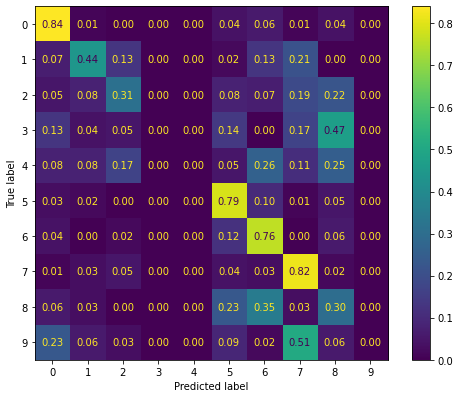

In [22]:
plt.figure(figsize=(8.8,6.5))
conf_matrix = confusion_matrix(labels, manual_classification, labels=classes, normalize="true")
conf_matrix_visualisation = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
conf_matrix_visualisation.plot(ax=plt.gca(), values_format=".2f")

The confusion matrix shows what percentage of the different true classes (y-axis) was classified correctly or incorrectly as another class (predicted label, x-axis). In case of a perfect classification, then major diagonal (top left to bottom right) will consist entirely out of 1.00.  

In addition to the confusion matrix, scikit-learn can also generate a more detailed classification report:

In [25]:
print(classification_report(labels, manual_classification, labels=classes, zero_division=0))

              precision    recall  f1-score   support

           0       0.55      0.84      0.66       100
           1       0.56      0.44      0.49       100
           2       0.41      0.31      0.35       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.49      0.79      0.61       100
           6       0.43      0.76      0.55       100
           7       0.40      0.82      0.54       100
           8       0.20      0.30      0.24       100
           9       0.00      0.00      0.00       100

    accuracy                           0.43      1000
   macro avg       0.30      0.43      0.34      1000
weighted avg       0.30      0.43      0.34      1000

